# Test technique PRO BTP Data Scientist - Open Data SNCF Dataset

# Stéphane PETIOT

## Import des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Récupération du dataset CSV

In [2]:
df_sncf = pd.read_csv('validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-1er-sem.csv', sep = ';')
df_sncf

,JOUR,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,LIBELLE_ARRET,ID_REFA_LDA,CATEGORIE_TITRE,NB_VALD
0,2020-01-03,800,852,432,LE PERRAY,62804.0,TST,Moins de 5
1,2020-01-03,800,852,515,MAREIL-SUR-MAULDRE,64572.0,NAVIGO,18
2,2020-01-03,800,852,526,MAULE,64674.0,AMETHYSTE,Moins de 5
3,2020-01-03,800,852,538,MEUDON,70515.0,TST,Moins de 5
4,2020-01-03,800,852,561,MONTPARNASSE,71139.0,IMAGINE R,1600
...,...,...,...,...,...,...,...,...
835136,2020-05-15,100,110,778,SAINT-PHILIPPE-DU-ROULE,71334.0,AMETHYSTE,19
835137,2020-05-15,100,110,778,SAINT-PHILIPPE-DU-ROULE,71334.0,NON DEFINI,18
835138,2020-05-15,100,110,780,SAINT-SEBASTIEN FROISSART,71777.0,AUTRE TITRE,37
835139,2020-05-15,100,110,781,SAINT-SULPICE,71202.0,AUTRE TITRE,41


## Exploration des données

In [3]:
# Description des différentes données d'entrées
pd.set_option('max_colwidth', None)
pd.DataFrame(
    data = {
        'VARIABLES' : ['JOUR', 'COD_STIF_TRNS', 'COD_STIF_RES', 'COD_STIF_ARRET', 'LIBELLE_ARRET', 'ID_REFA_LDA', 'CATEGORIE_TITRE', 'NB_VALD'],
        'FORMAT' : ['Date', 'Numérique', 'Numérique', 'Numérique', 'Caractère', 'Caractère', 'Caractère', 'Numérique'],
        'DEFINITION' : ['Jour d’exploitation (de 04:00 à 03:59 le lendemain)', 'Code Stif du transporteur', 'Code Stif du réseau', 'Code Stif de l’arrêt/station', 'Libellé de l’arrêt/station', 'Identifiant arrêt référentiel STIF', 'Titre de transport', 'Nombre de validations (en entrée sur le réseau)']
    }
).style.hide_index()

VARIABLES,FORMAT,DEFINITION
JOUR,Date,Jour d’exploitation (de 04:00 à 03:59 le lendemain)
COD_STIF_TRNS,Numérique,Code Stif du transporteur
COD_STIF_RES,Numérique,Code Stif du réseau
COD_STIF_ARRET,Numérique,Code Stif de l’arrêt/station
LIBELLE_ARRET,Caractère,Libellé de l’arrêt/station
ID_REFA_LDA,Caractère,Identifiant arrêt référentiel STIF
CATEGORIE_TITRE,Caractère,Titre de transport
NB_VALD,Numérique,Nombre de validations (en entrée sur le réseau)


In [4]:
# Assurons-nous que les données soient au bon format
df_sncf.dtypes

JOUR                object
CODE_STIF_TRNS       int64
CODE_STIF_RES       object
CODE_STIF_ARRET     object
LIBELLE_ARRET       object
ID_REFA_LDA        float64
CATEGORIE_TITRE     object
NB_VALD             object
dtype: object

## Pré-traitement et nettoyage des données

In [5]:
# Date : on utilise le format datetime de pandas
df_sncf['JOUR'] = pd.to_datetime(df_sncf['JOUR'])
#df_sncf = df_sncf.sort_values('JOUR')

# La connaissance de la date précise n'est pas forcément pertinente dans le cadre d'une prédiction de volume de transport
# Ce qui peut en revanche être pertinent, c'est de connaître le jour de la semaine ainsi que le mois de l'année, car l'affluence
# peut varier significativement en fonction de ces deux données
df_sncf['DayOfWeek'] = df_sncf['JOUR'].dt.dayofweek
df_sncf['Month'] = df_sncf['JOUR'].dt.month


In [6]:
# Dates :
df_sncf['DayOfWeek'] = pd.to_numeric(df_sncf['DayOfWeek'], downcast = 'unsigned')
df_sncf['Month'] = pd.to_numeric(df_sncf['Month'], downcast = 'unsigned')

# Codes STIF :
df_sncf['CODE_STIF_TRNS'] = pd.to_numeric(df_sncf['CODE_STIF_TRNS'], downcast = 'unsigned')
# Il existe quelques rares anomalies (Valeurs 'ND', Non Desservis ? Interruptions sur la ligne ?)
# On va donc utiliser une expression régulière (RegEx)
df_sncf['CODE_STIF_RES'] = pd.to_numeric(df_sncf['CODE_STIF_RES'].str.extract('(\d+)')[0].astype(float), downcast = 'unsigned')
df_sncf['CODE_STIF_ARRET'] = pd.to_numeric(df_sncf['CODE_STIF_ARRET'].str.extract('(\d+)')[0].astype(float), downcast = 'unsigned')

# Les Identifiants arrêt sont également des entiers naturels (initialement au format 'float')
df_sncf['ID_REFA_LDA'] = pd.to_numeric(df_sncf['ID_REFA_LDA'], downcast = 'unsigned')

In [7]:
# Vérification des formats
df_sncf.dtypes

JOUR               datetime64[ns]
CODE_STIF_TRNS             uint16
CODE_STIF_RES             float64
CODE_STIF_ARRET           float64
LIBELLE_ARRET              object
ID_REFA_LDA               float64
CATEGORIE_TITRE            object
NB_VALD                    object
DayOfWeek                   uint8
Month                       uint8
dtype: object

In [8]:
# La présence de valeurs non numériques dans les données empêche de caster les données de type float vers le type unsigned int
# Evaluons les données manquantes
pd.DataFrame(
    [df_sncf.isnull().sum(), (df_sncf.isnull().sum()/df_sncf.shape[0]) * 100],
    index = ['Total Missing Values', '% Missing Values']
)

,JOUR,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,LIBELLE_ARRET,ID_REFA_LDA,CATEGORIE_TITRE,NB_VALD,DayOfWeek,Month
Total Missing Values,0.0,0.0,772.000000,772.000000,0.0,43848.000000,0.0,0.0,0.0,0.0
% Missing Values,0.0,0.0,0.092439,0.092439,0.0,5.250371,0.0,0.0,0.0,0.0


In [9]:
df_sncf.dropna(subset = ['CODE_STIF_RES', 'CODE_STIF_ARRET'], inplace = True)

In [10]:
# Il y a toutefois quelques exceptions, certains ID_REFA_LDA sont associés à plusieurs CODE_STIF_ARRET
redundancy_df = df_sncf[['CODE_STIF_ARRET', 'ID_REFA_LDA']].groupby(['ID_REFA_LDA']).nunique()
#print(redundancy_df.loc[~((redundancy_df['CODE_STIF_ARRET'] == 1) & (redundancy_df['ID_REFA_LDA'] == 1))])

# Il y a également quelques CODE_STIF_ARRET qui n'ont pas de ID_REFA_LDA associés
redundancy_df = df_sncf[['ID_REFA_LDA', 'CODE_STIF_ARRET']].groupby(['CODE_STIF_ARRET']).nunique()
#print(redundancy_df.loc[~((redundancy_df['CODE_STIF_ARRET'] == 1) & (redundancy_df['ID_REFA_LDA'] == 1))])

# Ces exemples sont assez minoritaires dans l'ensemble des valeurs possibles, on va donc considérer que les CODE_STIF_ARRET et
# ID_REFA_LDA sont redondantes
df_sncf = df_sncf.drop('ID_REFA_LDA', axis = 1)

In [11]:
df_sncf['CODE_STIF_RES'] = pd.to_numeric(df_sncf['CODE_STIF_RES'], downcast = 'unsigned')
df_sncf['CODE_STIF_ARRET'] = pd.to_numeric(df_sncf['CODE_STIF_ARRET'], downcast = 'unsigned')
df_sncf.dtypes

JOUR               datetime64[ns]
CODE_STIF_TRNS             uint16
CODE_STIF_RES              uint16
CODE_STIF_ARRET            uint16
LIBELLE_ARRET              object
CATEGORIE_TITRE            object
NB_VALD                    object
DayOfWeek                   uint8
Month                       uint8
dtype: object

In [12]:
# Enfin, il s'agit de traiter la donnée NB_VALD, composée entièrement d'entiers naturels, à l'exception des échantillons pour
# lesquels la valeur est inférieure (stricte) à 5, auquel cas il est inscrit 'Moins de 5'. Il ne s'agit pas de valeurs
# minoritaires
print(df_sncf.loc[df_sncf['NB_VALD'] == 'Moins de 5'].shape[0])

161244


In [13]:
# Arbitrairement, on va donc affecter à ces données la valeur 3, pour indiquer qu'il s'agit d'un pass avec moins de 5 validations
df_sncf['NB_VALD'] = df_sncf['NB_VALD'].apply(lambda x : 3 if x == 'Moins de 5' else x)

In [14]:
df_sncf['NB_VALD'] = pd.to_numeric(df_sncf['NB_VALD'], downcast = 'unsigned')
df_sncf.dtypes

JOUR               datetime64[ns]
CODE_STIF_TRNS             uint16
CODE_STIF_RES              uint16
CODE_STIF_ARRET            uint16
LIBELLE_ARRET              object
CATEGORIE_TITRE            object
NB_VALD                    uint32
DayOfWeek                   uint8
Month                       uint8
dtype: object

In [15]:
df_sncf.corr().abs().style.applymap(lambda val : 'color : red' if val > 0.9 else 'color : black')

,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,NB_VALD,DayOfWeek,Month
CODE_STIF_TRNS,1.000000,0.998813,0.167322,0.068002,0.024506,0.013018
CODE_STIF_RES,0.998813,1.000000,0.165064,0.068645,0.024576,0.013338
CODE_STIF_ARRET,0.167322,0.165064,1.000000,0.033046,0.001413,0.000826
NB_VALD,0.068002,0.068645,0.033046,1.000000,0.044314,0.083494
DayOfWeek,0.024506,0.024576,0.001413,0.044314,1.000000,0.014686
Month,0.013018,0.013338,0.000826,0.083494,0.014686,1.000000


In [16]:
# Les features CODE_STIF_TRNS et CODE_STIF_RES sont corrélées à plus de 99%, elles sont donc porteuses de la même information
# On va donc conserver une seule de ces deux données d'entrée.
df_sncf = df_sncf.drop('CODE_STIF_RES', axis = 1)

In [17]:
# La phase de pré-traitement et de nettoyage des données est à présent terminée, et nous pouvons commencer notre analyse à
# partir du dataset suivant
df_sncf.head()

,JOUR,CODE_STIF_TRNS,CODE_STIF_ARRET,LIBELLE_ARRET,CATEGORIE_TITRE,NB_VALD,DayOfWeek,Month
0,2020-01-03,800,432,LE PERRAY,TST,3,4,1
1,2020-01-03,800,515,MAREIL-SUR-MAULDRE,NAVIGO,18,4,1
2,2020-01-03,800,526,MAULE,AMETHYSTE,3,4,1
3,2020-01-03,800,538,MEUDON,TST,3,4,1
4,2020-01-03,800,561,MONTPARNASSE,IMAGINE R,1600,4,1


## Question : Quelles sont les 20 premières stations en terme de validations ?

In [18]:
df_sncf_nbVal = df_sncf[['LIBELLE_ARRET', 'NB_VALD']].groupby('LIBELLE_ARRET').sum().sort_values('NB_VALD', ascending = False)
df_sncf_nbVal.head(20)

,NB_VALD
LIBELLE_ARRET,
SAINT-LAZARE,17775377
GARE DU NORD,7538501
MONTPARNASSE,6726059
GARE DE L'EST,5842491
LA DEFENSE-GRANDE ARCHE,5413369
GARE DE LYON,4077208
BIBLIOTHEQUE FRANCOIS MITTERRAND,3250739
LES HALLES,3033970
CHATELET-LES HALLES,2866968


## Question : Proposez une illustration graphique de ce classement

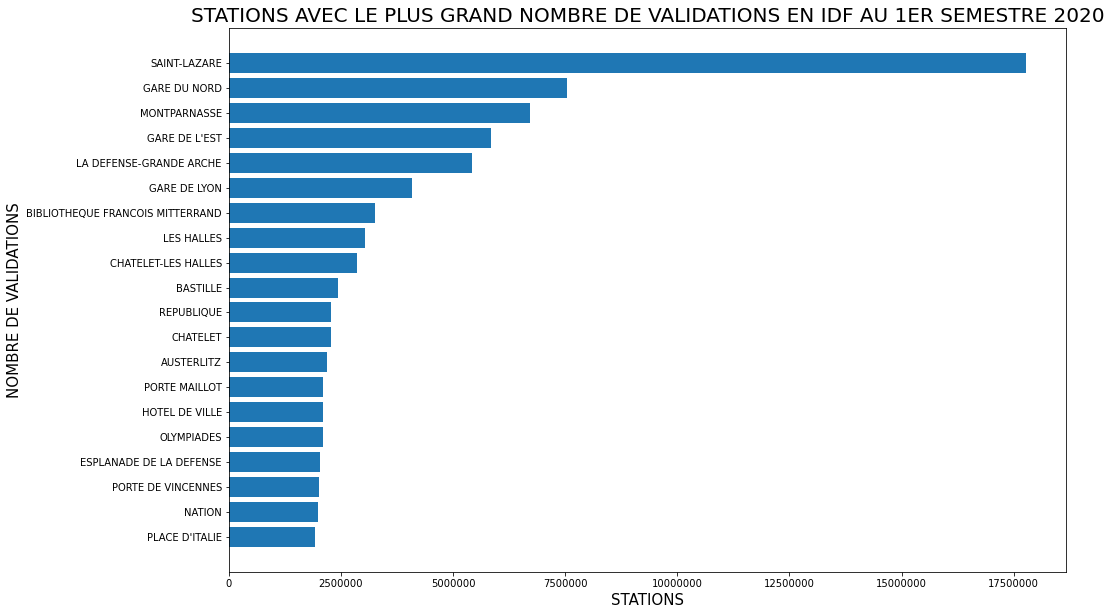

In [19]:
plt.figure(figsize = (15, 10))
plt.barh(df_sncf_nbVal.head(20)['NB_VALD'].sort_values().index, df_sncf_nbVal.head(20)['NB_VALD'].sort_values())
plt.ticklabel_format(style = 'plain', axis = 'x')
plt.title('STATIONS AVEC LE PLUS GRAND NOMBRE DE VALIDATIONS EN IDF AU 1ER SEMESTRE 2020', fontsize = 20)
plt.xlabel('STATIONS', fontsize = 15)
plt.ylabel('NOMBRE DE VALIDATIONS', fontsize = 15)
plt.show()

## Question : Proposez une classification des arrêts en vous basant sur le nombre de validations par catégorie de titre ?

In [20]:
# Décommenter pour affichage complet des DataFrames
#pd.set_option('display.max_rows', None)
# Décommenter pour réinitialiser l'option d'affichage
#pd.reset_option('display.max_rows')

# Un affichage des arrêts basé sur le nombre de validation par catégorie de titre est obtenue grâce à la méthode 'groupby' :
df_classif_sum = df_sncf[['LIBELLE_ARRET', 'NB_VALD', 'CATEGORIE_TITRE']].groupby(['LIBELLE_ARRET', 'CATEGORIE_TITRE']).sum()
df_classif_sum = df_classif_sum.groupby('LIBELLE_ARRET', as_index = True).apply(lambda x : x.sort_values('NB_VALD', ascending = False))
df_classif_sum = df_classif_sum.unstack()
df_classif_sum.index = df_classif_sum.index.droplevel(0)
df_classif_sum

NB_VALD                                           \
CATEGORIE_TITRE                    ? AMETHYSTE AUTRE TITRE      FGT IMAGINE R   
LIBELLE_ARRET                                                                   
ABBESSES                      1803.0    5994.0     11286.0   4489.0   41227.0   
ABLON                          230.0    2325.0         3.0   3250.0   16821.0   
ACHERES-GRAND-CORMIER          251.0     336.0         NaN    438.0     777.0   
ACHERES-VILLE                 7143.0    6450.0        69.0  14884.0   62839.0   
AEROPORT CHARLES DE GAULLE 1  6470.0    4254.0        36.0  15554.0   38663.0   
...                              ...       ...         ...      ...       ...   
VOLTAIRE (LEON BLUM)          8150.0   43109.0     29471.0  38139.0  137989.0   
VOSVES                          52.0      18.0         NaN     60.0     288.0   
VULAINES-SUR-SEINE-SAMOREAU    102.0     156.0         NaN    153.0     733.0   
WAGRAM                        3192.0    9319.0     19262.0   9761.0   79040.0   
YERRES                        8623.0    8296.0        42.0  12653.0   57326.0   

                                                                        
CATEGORIE_TITRE                 NAVIGO NAVIGO JOUR NON DEFINI      TST  
LIBELLE_ARRET                                                           
ABBESSES                      134192.0       612.0     3984.0   4614.0  
ABLON                          68285.0       191.0     1603.0   4804.0  
ACHERES-GRAND-CORMIER           3982.0        12.0      150.0    527.0  
ACHERES-VILLE                 246554.0       396.0     4144.0  26289.0  
AEROPORT CHARLES DE GAULLE 1  250652.0      1353.0     4494.0  25806.0  
...                                ...         ...        ...      ...  
VOLTAIRE (LEON BLUM)          636411.0       926.0    15766.0  49108.0  
VOSVES                           394.0         3.0        9.0     75.0  
VULAINES-SUR-SEINE-SAMOREAU     1405.0        27.0        9.0    216.0  
WAGRAM                        312686.0       440.0     5724.0  15882.0  
YERRES                        265871.0       520.0     3025.0  15624.0  

[676 rows x 9 columns]

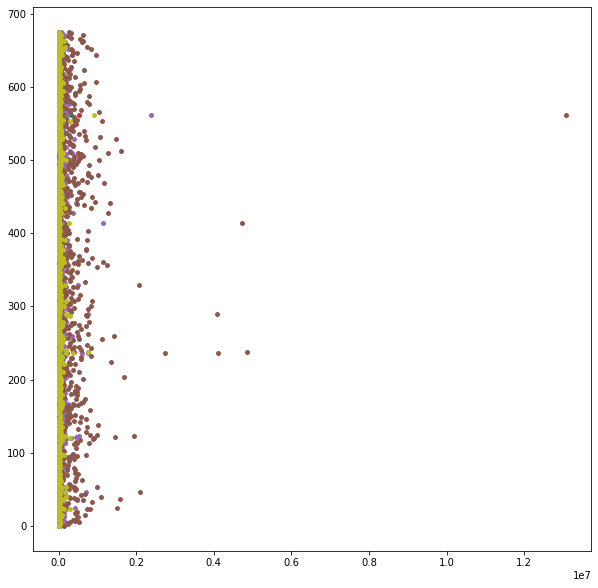

In [40]:
# Il peut être intéressant de visualiser graphiquement ce DataFrame
plt.figure(figsize = (10, 10))
for category in df_classif_sum['NB_VALD'].columns :
    plt.scatter(y = df_classif_sum.reset_index().index, x = df_classif_sum['NB_VALD'][category], s = 15)
plt.show()

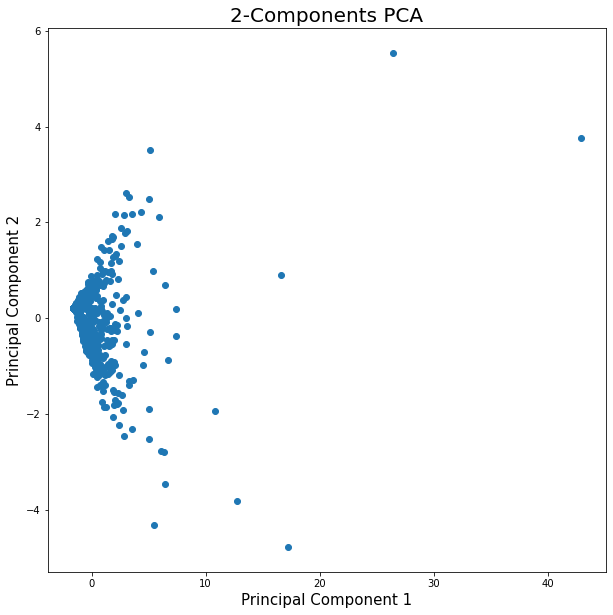

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM

features = ['?', 'AMETHYSTE', 'AUTRE TITRE', 'FGT', 'IMAGINE R', 'NAVIGO', 'NAVIGO JOUR', 'NON DEFINI', 'TST']
# Separating out the features
X = df_classif_sum['NB_VALD'].fillna(0).loc[:, features].values
# Standardizing the features
X = StandardScaler().fit_transform(X)

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['Principal Component 1', 'Principal Component 2'])
              
plt.figure(figsize = (10, 10))
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('2-Components PCA', fontsize = 20)
plt.scatter(principalDf['Principal Component 1'], principalDf['Principal Component 2'])
plt.show()

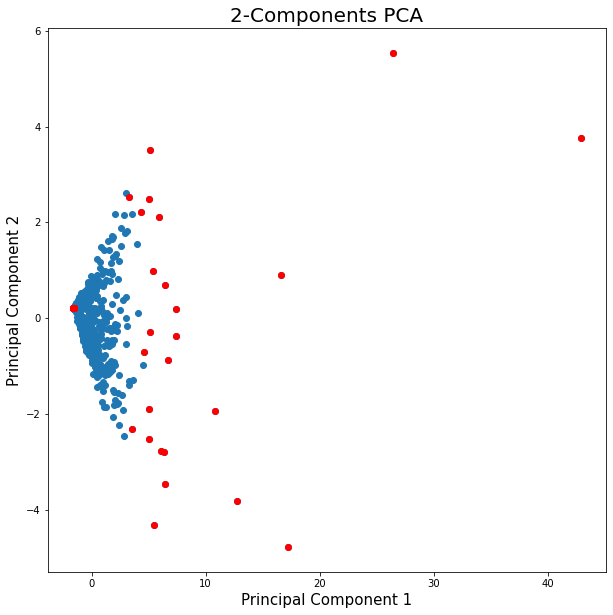

In [23]:
# model specification
model = OneClassSVM(kernel = 'rbf', gamma = 0.001, nu = 0.1).fit(principalDf)

# prediction
y_pred = model.predict(principalDf)
y_pred

# filter outlier index
outlier_index = np.where(y_pred == -1) 
# filter outlier values
outlier_values = principalDf.iloc[outlier_index]
outlier_values

# visualize outputs
plt.figure(figsize = (10, 10))
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('2-Components PCA', fontsize = 20)
plt.scatter(principalDf['Principal Component 1'], principalDf['Principal Component 2'])
plt.scatter(outlier_values['Principal Component 1'], outlier_values['Principal Component 2'], c = "r")
plt.show()

In [24]:
# L'affichage précédent n'est pas facilement exploitable, on remarque toutefois qu'il y a des outliers, c'est-à-dire des arrêts
# pour lesquels le nombre de validation associé à une catégorie de titre est particulièrement élevé
# On peut également s'intéresser à un autre feature, par exemple la moyenne des validations
df_classif_mean = df_sncf[['LIBELLE_ARRET', 'NB_VALD', 'CATEGORIE_TITRE']].groupby(['LIBELLE_ARRET', 'CATEGORIE_TITRE']).mean()
df_classif_mean = df_classif_mean.groupby('LIBELLE_ARRET', as_index = False).apply(lambda x : x.sort_values('NB_VALD', ascending = False))
df_classif_mean = df_classif_mean.unstack()
df_classif_mean.index = df_classif_mean.index.droplevel(0)
df_classif_mean

NB_VALD                                      \
CATEGORIE_TITRE                       ?   AMETHYSTE AUTRE TITRE         FGT   
LIBELLE_ARRET                                                                 
ABBESSES                      16.850467   62.437500  121.354839   47.252632   
ABLON                          3.026316   14.351852    3.000000   19.461078   
ACHERES-GRAND-CORMIER          3.060976    3.054545         NaN    3.041667   
ACHERES-VILLE                 55.804688   39.329268    3.000000   93.025000   
AEROPORT CHARLES DE GAULLE 1  48.646617   32.227273    3.000000  116.947368   
...                                 ...         ...         ...         ...   
VOLTAIRE (LEON BLUM)          44.780220  236.862637  161.928571  209.554945   
VOSVES                         3.250000    3.000000         NaN    3.000000   
VULAINES-SUR-SEINE-SAMOREAU    3.000000    3.000000         NaN    3.122449   
WAGRAM                        17.635359   51.486188  109.443182   53.928177   
YERRES                        65.824427   52.840764    3.000000   71.892045   

                                                                              \
CATEGORIE_TITRE                IMAGINE R       NAVIGO NAVIGO JOUR NON DEFINI   
LIBELLE_ARRET                                                                  
ABBESSES                      433.968421  1369.306122    7.948052  43.304348   
ABLON                          95.033898   377.265193    3.031746   9.212644   
ACHERES-GRAND-CORMIER           5.842105    23.844311    3.000000   3.000000   
ACHERES-VILLE                 387.895062  1362.176796    3.920792  28.000000   
AEROPORT CHARLES DE GAULLE 1  290.699248  1884.601504   10.570312  34.045455   
...                                  ...          ...         ...        ...   
VOLTAIRE (LEON BLUM)          758.181319  3496.763736    6.910448  86.626374   
VOSVES                          3.692308     4.329670    3.000000   3.000000   
VULAINES-SUR-SEINE-SAMOREAU     7.186275    12.324561    3.000000   3.000000   
WAGRAM                        436.685083  1727.546961    4.000000  32.338983   
YERRES                        323.875706  1460.829670    4.561404  17.385057   

                                          
CATEGORIE_TITRE                      TST  
LIBELLE_ARRET                             
ABBESSES                       48.568421  
ABLON                          27.930233  
ACHERES-GRAND-CORMIER           3.711268  
ACHERES-VILLE                 155.556213  
AEROPORT CHARLES DE GAULLE 1  194.030075  
...                                  ...  
VOLTAIRE (LEON BLUM)          269.824176  
VOSVES                          3.000000  
VULAINES-SUR-SEINE-SAMOREAU     3.000000  
WAGRAM                         87.745856  
YERRES                         95.852761  

[676 rows x 9 columns]

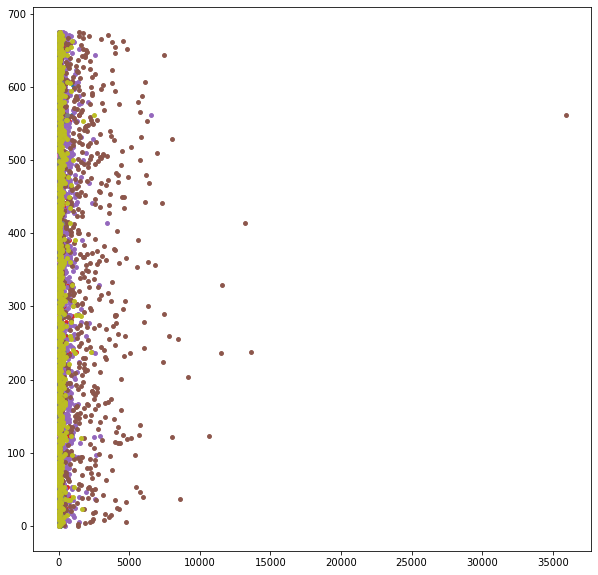

In [39]:
plt.figure(figsize = (10, 10))
for category in df_classif_mean['NB_VALD'].columns :
    plt.scatter(y = df_classif_mean.reset_index().index, x = df_classif_mean['NB_VALD'][category], s = 15)
plt.show()

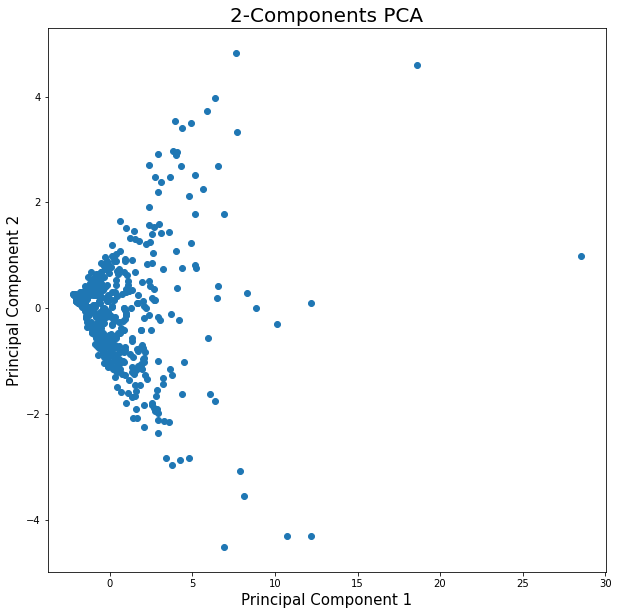

In [26]:
# Separating out the features
X = df_classif_mean['NB_VALD'].fillna(0).loc[:, features].values
# Standardizing the features
X = StandardScaler().fit_transform(X)

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['Principal Component 1', 'Principal Component 2'])
              
plt.figure(figsize = (10, 10))
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('2-Components PCA', fontsize = 20)
plt.scatter(principalDf['Principal Component 1'], principalDf['Principal Component 2'])
plt.show()

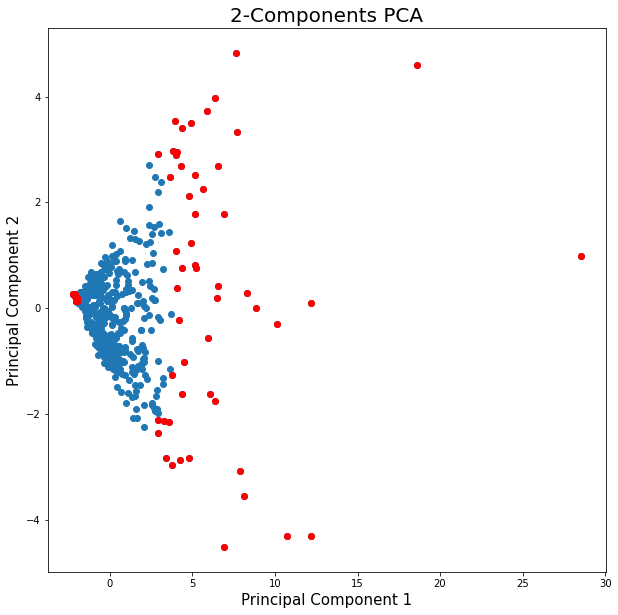

In [27]:
# model specification
model = OneClassSVM(kernel = 'rbf', gamma = 0.001, nu = 0.2).fit(principalDf)

# prediction
y_pred = model.predict(principalDf)
y_pred

# filter outlier index
outlier_index = np.where(y_pred == -1) 
# filter outlier values
outlier_values = principalDf.iloc[outlier_index]
outlier_values

# visualize outputs
plt.figure(figsize = (10, 10))
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('2-Components PCA', fontsize = 20)
plt.scatter(principalDf['Principal Component 1'], principalDf['Principal Component 2'])
plt.scatter(outlier_values['Principal Component 1'], outlier_values['Principal Component 2'], c = "r")
plt.show()

### ANNEXES : Pistes pour faire de la prediction d'arrêts (à ne pas prendre en compte)

In [28]:
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.preprocessing import LabelEncoder

# IL S'AGIT D'UTILISER DES DONNEES CATEGORIELLES : CATEGORIE_TITRE
# Il faut donc les encoder
# One-Hot Encoding : Adapté et pertinent lorsqu'il n'y a que peu de catégories différentes
#df_sncf = pd.concat([df_sncf.drop('CATEGORIE_TITRE', axis = 1), pd.get_dummies(df_sncf['CATEGORIE_TITRE'], prefix = 'CATEGORIE_TITRE')], axis = 1)

# Label Encoding :
# le = LabelEncoder()
# df_sncf['CATEGORIE_TITRE'] = le.fit_transform(df_sncf['CATEGORIE_TITRE'])

In [29]:
# X = df_sncf[['CATEGORIE_TITRE_?', 'CATEGORIE_TITRE_AMETHYSTE', 'CATEGORIE_TITRE_AUTRE TITRE', 'CATEGORIE_TITRE_FGT', 'CATEGORIE_TITRE_IMAGINE R', 'CATEGORIE_TITRE_NAVIGO', 'CATEGORIE_TITRE_NAVIGO JOUR', 'CATEGORIE_TITRE_NON DEFINI', 'CATEGORIE_TITRE_TST', 'NB_VALD']]
# Y = df_sncf['LIBELLE_ARRET']

# Pour réduire le biais dans les données (certaines catégories sont plus représentées que d'autres), on sample n données dans
# chaque catégorie (n étant la cardinalité de la catégorie la moins représentée)
# gb = df_sncf[['CATEGORIE_TITRE_?', 'CATEGORIE_TITRE_AMETHYSTE', 'CATEGORIE_TITRE_AUTRE TITRE', 'CATEGORIE_TITRE_FGT', 'CATEGORIE_TITRE_IMAGINE R', 'CATEGORIE_TITRE_NAVIGO', 'CATEGORIE_TITRE_NAVIGO JOUR', 'CATEGORIE_TITRE_NON DEFINI', 'CATEGORIE_TITRE_TST', 'NB_VALD', 'LIBELLE_ARRET']].groupby(['LIBELLE_ARRET'])
# blocks = [data.sample(n = 20, replace = False) for _, data in gb]
# df_sampled = pd.concat(blocks)
# df_sampled = df_sampled.sample(frac = 1)
# X = df_sampled[['CATEGORIE_TITRE_?', 'CATEGORIE_TITRE_AMETHYSTE', 'CATEGORIE_TITRE_AUTRE TITRE', 'CATEGORIE_TITRE_FGT', 'CATEGORIE_TITRE_IMAGINE R', 'CATEGORIE_TITRE_NAVIGO', 'CATEGORIE_TITRE_NAVIGO JOUR', 'CATEGORIE_TITRE_NON DEFINI', 'CATEGORIE_TITRE_TST', 'NB_VALD']]
# Y = df_sampled['LIBELLE_ARRET']

# Séparation du dataset
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 1)
# for col in X_train.columns :
#     X_train[col] = pd.to_numeric(X_train[col], downcast = 'unsigned')

# Standardisation des données
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [30]:
# Classification k-NN, SVM et Random Forest
#knnClassifier = KNeighborsClassifier(5)
#SvClassifier = SVC(C = 1, kernel = 'rbf', random_state = 1)
#rfClassifier = RandomForestClassifier(n_estimators = 50, n_jobs = 2, max_depth = 10, random_state = 1)

#knnClassifier.fit(np.array(X_train), Y_train)
#rfClassifier.fit(X_train, Y_train)
#SvClassifier.fit(X_train, Y_train)

In [31]:
# La classification sur un grand nombre de catégories est difficile avec un classifieur simple comme un kNN ou un SVC
# Pour parvenir à de meilleurs résultats, on effectue une classification bi-classe sur chacune des catégories
# Puis on agrege les résultats
# Il s'agit d'une approche One-vs-Rest
#OvR_classifier = OneVsRestClassifier(rfClassifier)
#OvR_classifier.fit(X_train, Y_train)

# Y_predict = rfClassifier.predict(X_test)
# Y_predict = OvR_classifier.predict(X_train)
# Y_predict = rfClassifier.predict(X_test)
#Y_predict = OvR_classifier.predict(X_test)

#print(accuracy_score(Y_predict, Y_test))
#pd.DataFrame({'Y_predict' : np.array(Y_predict), 'Y_test' : np.array(Y_test)})

## Question : Quelles prédictions pouvez vous faire pour le nombre de validations dans les stations "OLYMPIADES" et "M. MONTROUGE" sur la plage du 24 au 30 juin ?

In [32]:
# Les features présentant un petit nombre de valeurs uniques sont : CODE_STIF_TRNS, CATEGORIE_TITRE, DayOfWeek et Month
# print(str(len(df_sncf['CODE_STIF_TRNS'].unique())) + ' CODE_STIF_TRNS possibles : ' + str(df_sncf['CODE_STIF_TRNS'].unique()))
# print(str(len(df_sncf['CATEGORIE_TITRE'].unique())) + ' CATEGORIE_TITRE possibles : ' + str(df_sncf['CATEGORIE_TITRE'].unique()))
# print(str(len(df_sncf['DayOfWeek'].unique())) + ' DayOfWeek possibles : ' + str(df_sncf['DayOfWeek'].sort_values().unique()))
# print(str(len(df_sncf['Month'].unique())) + ' Month possibles : ' + str(df_sncf['Month'].unique()))

# En revanche, CODE_STIF_ARRET représente un arrêt/station parmi un grand nombre de possibilités
# print(str(len(df_sncf['CODE_STIF_ARRET'].unique())) + ' CODE_STIF_ARRET possibles : ' + str(df_sncf['CODE_STIF_ARRET'].unique()))

# On va donc utiliser une approche Binary pour la feature CODE_STIF_ARRET
# Ceci est possible en utilisant le LabelBinarizer de Scikit-Learn
# !pip install category_encoders
# import category_encoders as ce

# be = ce.BinaryEncoder(cols = ['CODE_STIF_ARRET'])
# df_sncf = pd.concat([df_sncf.drop('CODE_STIF_ARRET', axis = 1), be.fit_transform(df_sncf['CODE_STIF_ARRET'])], axis = 1)

In [33]:
# Dans notre cas, Olympiades et Mairie de Montrouge sont deux stations de métro donc la connaissance de leur CODE_STIF_TRNS
# associé n'est pas pertinente
# On peut aussi se limiter à la seule donnée 'LIBELLE_ARRET' plutôt que de conserver également 'CODE_STIF_ARRET'
df_sncf = df_sncf.drop(['CODE_STIF_TRNS', 'CODE_STIF_ARRET'], axis = 1)

In [34]:
# On va donc utiliser une approche One-Hot pour encoder les features CODE_STIF_TRNS, CATEGORIE_TITRE, DayOfWeek et Month
# Ceci est possible grâce à la méhode get_dummies de Pandas
df_sncf = pd.concat([df_sncf.drop('CATEGORIE_TITRE', axis = 1), pd.get_dummies(df_sncf['CATEGORIE_TITRE'], prefix = 'CATEGORIE_TITRE')], axis = 1)
df_sncf = pd.concat([df_sncf.drop('DayOfWeek', axis = 1), pd.get_dummies(df_sncf['DayOfWeek'], prefix = 'DayOfWeek')], axis = 1)
df_sncf = pd.concat([df_sncf.drop('Month', axis = 1), pd.get_dummies(df_sncf['Month'], prefix = 'Month')], axis = 1)
df_sncf.columns

Index(['JOUR', 'LIBELLE_ARRET', 'NB_VALD', 'CATEGORIE_TITRE_?',
       'CATEGORIE_TITRE_AMETHYSTE', 'CATEGORIE_TITRE_AUTRE TITRE',
       'CATEGORIE_TITRE_FGT', 'CATEGORIE_TITRE_IMAGINE R',
       'CATEGORIE_TITRE_NAVIGO', 'CATEGORIE_TITRE_NAVIGO JOUR',
       'CATEGORIE_TITRE_NON DEFINI', 'CATEGORIE_TITRE_TST', 'DayOfWeek_0',
       'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
       'DayOfWeek_5', 'DayOfWeek_6', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6'],
      dtype='object')

In [35]:
df_sncf = df_sncf.loc[((df_sncf['LIBELLE_ARRET'] == 'M. MONTROUGE') | (df_sncf['LIBELLE_ARRET'] == 'OLYMPIADES'))]
df_sncf.shape

(3142, 25)

In [36]:
df_sncf_target = df_sncf.loc[
    (df_sncf['JOUR'] >= '2020-06-24') &
    (df_sncf['JOUR'] <= '2020-06-30')
]
df_sncf = df_sncf.loc[~(
    (df_sncf['JOUR'] >= '2020-06-24') &
    (df_sncf['JOUR'] <= '2020-06-30')
)]
df_sncf = df_sncf.drop('JOUR', axis = 1)
df_sncf_target = df_sncf_target.drop('JOUR', axis = 1)
df_sncf.columns

Index(['LIBELLE_ARRET', 'NB_VALD', 'CATEGORIE_TITRE_?',
       'CATEGORIE_TITRE_AMETHYSTE', 'CATEGORIE_TITRE_AUTRE TITRE',
       'CATEGORIE_TITRE_FGT', 'CATEGORIE_TITRE_IMAGINE R',
       'CATEGORIE_TITRE_NAVIGO', 'CATEGORIE_TITRE_NAVIGO JOUR',
       'CATEGORIE_TITRE_NON DEFINI', 'CATEGORIE_TITRE_TST', 'DayOfWeek_0',
       'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
       'DayOfWeek_5', 'DayOfWeek_6', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6'],
      dtype='object')

In [37]:
# On constate qu'une regression linéaire classique ne fonctionne pas avec notre jeu de donnée
!pip install xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X = df_sncf[df_sncf.columns[1:]]
Y = df_sncf['NB_VALD']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 1)

regressor = XGBRegressor(n_estimators = 500, learning_rate = 0.05, n_jobs = 2)
regressor.fit(X_train, Y_train,
             early_stopping_rounds = 5, 
             eval_set = [(X_test, Y_test)],
             verbose = False)
predicted = regressor.predict(X_test)

print("MAE : " + str(mean_absolute_error(Y_test, predicted)))
pd.DataFrame({'Predicted' : predicted, 'Real' : Y_test})

MAE : 2.867838972451671


,Predicted,Real
314814,20.994053,21
505989,748.562683,743
484425,537.575928,535
586603,3.123513,3
401613,17.034868,17
...,...,...
369516,586.029602,585
696996,164.879562,165
545974,137.022812,137
446602,1447.233276,1438


In [38]:
Target_predictions = regressor.predict(df_sncf_target[df_sncf_target.columns[1:]])

print("MAE : " + str(mean_absolute_error(df_sncf_target['NB_VALD'], Target_predictions)))
pd.DataFrame({'Predicted' : Target_predictions, 'Real' : df_sncf_target['NB_VALD']})

MAE : 3.119435264950707


,Predicted,Real
42225,213.618134,214
42227,407.935059,409
42228,1828.638184,1842
42275,99.169250,98
42277,5235.633789,5239
...,...,...
784108,1381.952271,1383
784109,3757.305908,3755
784110,142.745895,142
785678,43.261902,43
